## Multi-Modal Face Anti Spoofing
> 该项目是基于多模态数据的`**活体检测模型**`，主要通过ResNeXt融合SE模块学习人脸细节图像块，让模型集中筛选活体和非活体的细微特征。由于想要把训练好的模型用于`**遮挡状态下的活体人脸身份识别项目**`，需要使用视频截取的RGB图片作为输入，因此着重对单模态模型进行训练，但是为了使`**活体检测模型**`能更灵活地适用于不同场景，在创建数据集和构建模型的时候仍把多模态考虑在内，方面后续随时可以按不同项目的具体情况需求进行调用。

项目过程中的主要困难点、亮点和相关方案：
- 模型结构：设计组合backbone、SE-block和fusion block的不同搭配
- 消融实验：对比了单模态/多模态等多种模型结构，以及在不同学习率和lr scheduler设置下的训练结果
- 模型加速：V100 GPU提速，以及相关tricks的调参
- 模型checkpoints训练日志：通过同步保存optimizer和scheduler状态，根据日志信息，基于上一个保存的最优模型继续训练，最大限度抑制再训练可能导致的反弹情况，逐步迭代最小化ACER
- 模型压缩：由于模型结构较复杂，裁剪filter后容易出现问题，仍待进一步研究更好的压缩方式，如混合精度等
- 项目文件的导入路径问题：使用sys.path更新项目环境路径
- 项目整合：整合项目所有文件和参数配置，方便在终端通过命令或执行脚本指定参数，从而开启自定义训练
- 模型部署：整合预训练模型，并通过class实例化调用

In [4]:
# Analysis
import os
import numpy as np
import pandas as pd
import math
import random
import glob

# Plotting
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus']=False 

# Framework
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms
from torch.utils import model_zoo

> ### Data

#### CASIA_SURF Dataset
`casia_surf_dataset/load_data.py`：以下流程先用简易版数据`train_list_small.txt`验证代码，后续再用原数据`train_list.txt`进行训练。

In [80]:
DATA_ROOT = 'casia_surf_dataset' 
# TRAIN_LIST = 'train_list_small.txt'
TRAIN_LIST = 'train_list.txt' 
VAL_LIST = 'val_private_list.txt'
TEST_LIST = 'test_private_list.txt'

In [73]:
def load_data_list(path):  #包括多模态的图片路径和对应label
    data = pd.read_csv(path, sep=' ', names=['color','depth','ir','label'])
    n_pos = len(data[data['label']==1])
    n_neg = len(data[data['label']==0])
    print(f'We have loaded {data.shape[0]} samples: {n_pos} real faces, and {n_neg} fake faces.')
    return data

In [4]:
train = load_data_list(os.path.join(DATA_ROOT,TRAIN_LIST))
train.head()

We have loaded 29266 samples: 8942 real faces, and 20324 fake faces.


,color,depth,ir,label
0,Training/fake_part/CLKJ_AS0005/04_en_b.rssdk/c...,Training/fake_part/CLKJ_AS0005/04_en_b.rssdk/d...,Training/fake_part/CLKJ_AS0005/04_en_b.rssdk/i...,0
1,Training/fake_part/CLKJ_AS0005/04_en_b.rssdk/c...,Training/fake_part/CLKJ_AS0005/04_en_b.rssdk/d...,Training/fake_part/CLKJ_AS0005/04_en_b.rssdk/i...,0
2,Training/fake_part/CLKJ_AS0005/04_en_b.rssdk/c...,Training/fake_part/CLKJ_AS0005/04_en_b.rssdk/d...,Training/fake_part/CLKJ_AS0005/04_en_b.rssdk/i...,0
3,Training/fake_part/CLKJ_AS0005/04_en_b.rssdk/c...,Training/fake_part/CLKJ_AS0005/04_en_b.rssdk/d...,Training/fake_part/CLKJ_AS0005/04_en_b.rssdk/i...,0
4,Training/fake_part/CLKJ_AS0005/04_en_b.rssdk/c...,Training/fake_part/CLKJ_AS0005/04_en_b.rssdk/d...,Training/fake_part/CLKJ_AS0005/04_en_b.rssdk/i...,0


In [102]:
def show_sample(idx, data): #查看样本的多模态图
    samples = data.iloc[idx]
    titles = data.columns
    plt.subplots(1,3)
    for i in range(3):
        plt.subplot(1,3,i+1)
        img = plt.imread(os.path.join(DATA_ROOT,samples[i]))
        plt.imshow(img)
        plt.title(f'{titles[i]}: {img.shape}')
        plt.axis(False)

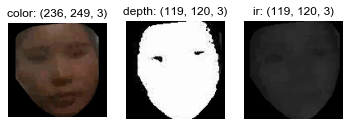

In [103]:
n_train = train.shape[0]
idx = np.random.choice(n_train)
show_sample(idx, train)

#### Data Augumentation
`preprocess/augmentation.py`

In [13]:
from imgaug import augmenters as iaa

In [206]:
IMAGE_SIZE = 112 #多模态样本尺寸
PATCH_SIZE = 48 #样本crop尺寸

In [15]:
def TTA_crops(image, target_shape=(32, 32, 3), n_patches=36):
    '''
    Parameters
    ----------
    n_patches : int
                每张图片截取的patches数目，包括：
                5: 中间十字5个patch，共1*5=5种patches
                18：中间9宫格，原patch+1种翻转，共2*9=18种patches
                36: 中间9宫格，原patch+3种翻转，共4*9=36种patches
    '''
    
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    width, height, d = image.shape
    target_w, target_h, d = target_shape
    start_x = ( width - target_w) // 2
    start_y = ( height - target_h) // 2

    #取原图正中间的9方格
    starts = [[start_x, start_y], #中点

              [start_x - target_w, start_y], #十字
              [start_x, start_y - target_h],
              [start_x + target_w, start_y],
              [start_x, start_y + target_h],

              [start_x + target_w, start_y + target_h], #四角
              [start_x - target_w, start_y - target_h],
              [start_x - target_w, start_y + target_h],
              [start_x + target_w, start_y - target_h],
              ]

    if n_patches == 5:
        starts = starts[:5] #只选取原图正中间的十字5方格
    
    images = []
    for start_index in starts:
        x, y = start_index
        
        # 如果超出左/上边，往右/下移
        if x < 0:
            x = 0
        if y < 0:
            y = 0
        
        # 如果超出右/下边，往左/上移
        if x + target_w >= IMAGE_SIZE:
            x = IMAGE_SIZE - target_w-1
        if y + target_h >= IMAGE_SIZE:
            y = IMAGE_SIZE - target_h-1

        # 截取每个patch的形状
        image_ = image.copy() #深拷贝，不改变原图
        image_ = image_[x:x + target_w, y: y+target_h, :]
        if n_patches >= 5:
            images.append(image_[np.newaxis,...]) #(1,h,w,c)
        if n_patches >=18:
            image_flip_lr = np.fliplr(image_.copy())
            images.append(image_flip_lr[np.newaxis,...])
        if n_patches >=36:
            image_flip_up = np.flipud(image_.copy())
            image_flip_lr_up = np.fliplr(np.flipud(image_.copy()))
            images.append(image_flip_up[np.newaxis,...])
            images.append(image_flip_lr_up[np.newaxis,...])

    return images

In [16]:
def random_resize(img, probability = 0.5,  minRatio = 0.2):
    if random.uniform(0, 1) > probability:
        return img #有一半的机会返回原图

    ratio = random.uniform(minRatio, 1.0)
    h, w, c = img.shape
    new_h = int(h*ratio) 
    new_w = int(w*ratio)
    img = cv2.resize(img, (new_w,new_h)) #随机缩小后
    img = cv2.resize(img, (w,h)) #再放大，由于插值法不同，像素值会有所改变
    return img

def random_cropping(image, target_shape=(32, 32, 3), is_random = True):
    image = cv2.resize(image,(IMAGE_SIZE,IMAGE_SIZE))
    target_h, target_w,_ = target_shape
    height, width, _ = image.shape
    
    if is_random:
        start_x = random.randint(0, width - target_w)
        start_y = random.randint(0, height - target_h)
    else:
        start_x = ( width - target_w ) // 2
        start_y = ( height - target_h ) // 2

    zeros = image[start_y:start_y+target_h,start_x:start_x+target_w,:]
    return zeros

In [17]:
def augumentor(image, target_shape=(32, 32, 3), is_infer=False, n_patches=36):
    if is_infer: #通过各种随机变换后，返回多个patches
        # augment_img = iaa.Sequential([iaa.Fliplr(0)])
        # image =  augment_img.augment_image(image)
        image = TTA_crops(image, target_shape, n_patches) #返回列表[(1,h,w,c),...]
        image = np.concatenate(image, axis=0) #(n,h,w,c)
        return image

    else: #通过各种随机变换后，再随机resize和crop成1个patch
        augment_img = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5),
            iaa.Affine(rotate=(-30, 30)),
        ], random_order=True)
        image = augment_img.augment_image(image)
        image = random_resize(image) #但是随机缩小之后，又恢复原大小不是没意义？
        image = random_cropping(image, target_shape, is_random=True) #如果需要各模态取同个位置，可以拼接后再crop
        return image

#### Create Dataset
`preprocess/dataset.py`

In [18]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import multiprocessing

In [19]:
class FDDataset(Dataset):
    def __init__(self, mode='train', modality='fusion', patch_size=32, balance = True):
        super(FDDataset, self).__init__()
        self.mode = mode #train/val/test
        self.modality = modality #color/depth/ir/fusion
        self.balance = balance
        self.patch_size = patch_size 
        self.set_mode(self.mode) #根据不同mode读取数据列表

    def set_mode(self, mode):
        self.mode = mode
        path_list = {'train':TRAIN_LIST,
                     'val': VAL_LIST,
                     'test': TEST_LIST}
        
        print(f'Loading {self.mode} dataset...')
        self.data_list = load_data_list(os.path.join(DATA_ROOT, path_list[self.mode])) #用pandas导入数据

    def preprocess(self, image_path):
        image = cv2.imread(os.path.join(DATA_ROOT, image_path))
        image = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE))
        if self.mode == 'train': #根据mode，得到单个/多个patches
            is_infer=False #(h,w,c)
        elif self.mode in ['val','test']:
            is_infer=True #(n,h,w,c)
        image = augumentor(image, target_shape=(self.patch_size, self.patch_size, 3), 
                               is_infer=is_infer, n_patches=36)
        return image    
    
    def __getitem__(self, idx):
        # 从数据列表中读取样本
        if self.balance: #如果要均衡样本，证明是train
            label = np.random.choice([0,1], p=[0.5,0.5]) #pos和neg相同采样比例
            data = self.data_list[self.data_list['label']==label] #选择pos/neg
            idx = np.random.choice(len(data)) #随机选取样本
        else: #否则，取出指定idx的样本
            data = self.data_list #候选数据
        color_path, depth_path, ir_path, label = data.iloc[idx] #样本路径和label
         
        # 处理标签
        if self.mode in ['train','val']:
            label = torch.LongTensor([int(label)]) #数字int64
        elif self.mode == 'test': #为了统一格式，设置test的label为Nan方便导入
            label = color_path+' '+depth_path+' '+ir_path #字符串
            
        # 根据模态和mode，得到统一尺寸的单模态图/多模态图，以及单个/多个patches
        if self.modality=='fusion':
            color = self.preprocess(color_path) #(h,w,3)/(n,h,w,3)
            depth = self.preprocess(depth_path)
            ir = self.preprocess(ir_path) 
            image = np.concatenate([color, depth, ir], axis=-1) #(h,w,9)/(n,h,w,9)
        elif self.modality=='color':
            image = self.preprocess(color_path) #(h,w,3)/(n,h,w,3)
        elif self.modality=='depth':
            image = self.preprocess(depth_path)
        elif self.modality=='ir':
            image = self.preprocess(ir_path)
          
        # 根据mode，得到单个/多个patches
        if self.mode == 'train':
            if self.modality=='fusion': # MFE对1个随机模态dropout归零
                if np.random.randint(0,2) == 0: #50%概率会dropout任意模态
                    mfe_idx = np.random.choice(3) #从3个模态种随机选择1个
                    if np.random.randint(0,2) == 0: #25%概率会dropout 1个模态
                        image[:,:,3*mfe_idx:3*(mfe_idx+1)] = 0
                    else:
                        for i in range(3):
                            if i != mfe_idx: #25%概率会dropout 2个模态
                                image[:,:,3*mfe_idx:3*(mfe_idx+1)] = 0
            image = np.transpose(image, (2, 0, 1)) #(9,h,w)/(3,h,w)            
                            
        elif self.mode in ['val','test']:
            image = np.transpose(image, (0, 3, 1, 2)) #(n,9,h,w)/(n,3,h,w)

        # 归一化输出patches和label
        image = image.astype(np.float32)
        image = image / 255.0
        image = torch.FloatTensor(image) #返回float32
        return image, label 

    
    def __len__(self):
        return len(self.data_list)

**<问题>** 初期用CPU训练时发现每个epoch的耗时太长，后期转用GPU但是耗时更长，用Nividia-smi发现显存占用率不高，且利用率为0%，因此记录每个epoch内各自操作的时间，以下为当时使用了num_workers=0主进程加载数据的结果：
- 最初在CPU上训练：每个batch耗时6s，大概2s加载数据，3.5s训练，训练1个epoch大概25min。   
- 后续在Colab Tesla K80 GPU上训练：每个batch耗时12s，高达11s在加载数据，但只需0.18s做运算，GPU大部分时间在闲置，没有利用好资源
- 再后续更换成在百度AI Studio上用V100 GPU (16GB RAM, 24 CPU cores) 训练：资本的味道!!飞速每个batch耗时1s，1s加载数据，0.03s做运算，训练1个epoch大概5min!!

1. num_workers  
用于并行加载数据到内存RAM的子进程数，当num_workers>0时，主进程不参与加载数据。假设用4个子进程根据主进程batch_sampler分配的index_queue并行加载每个batch，然后返回到主进程的data_queue，每轮迭代dataloader在RAM中按顺序寻找需要的batch，但由于4个子进程加载batches的速度不太一样，若batches #2/3/4最先加载完成，也需要在缓存中等待，直到batch #1加载完成，dataloader再交给GPU快速运算，然后马上进入下一个循环，由于剩下的3个batches已经在第一轮迭代时加载完毕，因此可以马上交给GPU快速处理，完成4个batches后，由于子进程们还在加载下一批数据，GPU因而闲置，相当于每4个迭代就会迎来1个空档期，当加载时间缩短到和运算时间差不多时，就能尽可能充分利用CPU和GPU。可以通过增加子进程个数缩小时间差：
    - 若num_workers太大，CPU加载大量数据到内存RAM，虽然速度快，但是若dataloader没有在RAM找到需要的batch，累积的数据可能会爆内存。同时由于进程间调度也需要耗时，过多的子进程也会导致低效。建议设置为CPU核心数，若CPU很强劲而且内存很大，也可以考虑适当再增加子进程数。
    - 同时batch size也会影响num_workers，增加batch size可以利用并行运算加快训练速度，但是太大的话，加载数据时也会有I/O问题，训练也容易爆GPU显存。

2. pin_memory  
主机中的内存，分为锁页(在任何情况下都不会与主机硬盘进行交换)，和不锁页(内存不足时，会存放在硬盘中)。当内存充足时，可以设置True，让子进程加载数据后返回到锁页内存的worker_result_queue，然后主进程的pin_memory_thread会从中读取数据放到data_queue，再复制到GPU显存(锁页内存)的固定区域中，实现GPU异步读取数据，速度快很多，同时设置images.to(device, non_blocking=True)

3. cuDNN Autotuner   
Nvidia的cuDNN支持用不同算法运算固定input size的CNN，设置torch.backends.cudnn.benchmark=True，首次运行时会试图根据hardware和input size找到能最优化运算成本的算法benchmark，后续迭代就会速度更快

5. I/O瓶颈  
由于需要频繁读取图像，可以考虑降低读取次数来提高速度，对于大规模的小图，建议转成二进制文件，打包保存成单独的文件，如TFRecord，pth、lmdb数据库等

6. 计算性能瓶颈  
保存为bmp文件降低解码时间（一般是numpy格式）

**<改进和结果>**   
通过遍历0-16个num_workers，计时每个batch的加载时间，找到不同配置下的最优参数值：
- CPU: 当num_workers从0增加到4，每个batch加载的时间相当，大概为0.003s，速度比原来提升超过10倍，但如果再继续加到和下面GPU一样的16个子进程，就会再次变慢为0.01s，因此决定保留4即CPU核
- GPU: 把num_workers从0逐步增加到16，加上pin_memory=True后速度进一步提升，平均每个batch加载0.8s，1个epoch需要大概3min。但是用AI Studio跑时，到了需要加载train和validation data的epoch就非常容易爆RAM，报错ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm)。因为在服务器上的docker中运行训练代码时，docker限制了shm，为避免类似情况，可以减小Validation的batch size为128//32，同时调整num_workers为4，或者把shm-size提高到8G

In [66]:
BATCH_SIZE = 128
PATCH_SIZE = 48

In [71]:
if __name__ =='__main__': #若num_workers>0，需要放在main下执行
    train_dataset = FDDataset(mode = 'train', modality='color', patch_size=PATCH_SIZE)
    train_loader  = DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE, drop_last = True, 
                               num_workers=0, #默认用0主进程加载数据，可以用多个子进程并行加载加快速度
                               prefetch_factor=2) #每个子进程预加载的sample数量，仅用于多进程

Loading train dataset...
Fold index set:  -1
We have loaded 29266 samples: 8942 real faces, and 20324 fake faces.


In [68]:
valid_dataset = FDDataset(mode ='val', modality='color', patch_size=PATCH_SIZE)
valid_loader  = DataLoader(valid_dataset, shuffle=False, batch_size = BATCH_SIZE, drop_last = False, 
                           num_workers=0)

Loading val dataset...
Fold index set:  -1
We have loaded 9608 samples: 2994 real faces, and 6614 fake faces.


In [22]:
for image, label in train_loader: 
    image.shape
    label.shape #记得对于label求loss时，cross_entropy要转成(n,)
    break

torch.Size([128, 9, 48, 48])

torch.Size([128, 1])

In [117]:
def show_sample(image, label):
    plt.subplots(1,3)
    for i in range(3):
        plt.subplot(1,3,i+1)
        img = image[...,i*3:(i+1)*3]
        plt.imshow(img)
        plt.axis(False)

torch.Size([48, 48, 9])

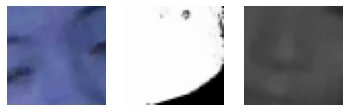

In [120]:
images, label = train_dataset[0] #调用__getitem__
images = np.transpose(images, (1,2,0)) #(h,w,c)
images.shape
show_sample(images, label)

> ### Single Modal Model

`model/net.py`：模型共用的网络函数

In [34]:
class Net(nn.Module):
    def normalize(self, x):
        # 通过bn或者RGB的mean,std进行数据normalization
        if self.is_first_bn:
            x = self.first_bn(x)
        else:
            mean=[0.485, 0.456, 0.406] #rgb
            std =[0.229, 0.224, 0.225]
            x = torch.cat([
                (x[:,[0]]-mean[0])/std[0],
                (x[:,[1]]-mean[1])/std[1],
                (x[:,[2]]-mean[2])/std[2],
            ],1)
        return x
    
    def load_checkpoint(self, pretrained_path, device):
        # 预加载自己训练的模型
        checkpoint = torch.load(pretrained_path, map_location=device) #用gpu加载state_dict
        # 因为有放进去nn.DataParallel(model)，所以模型会在module里
        self.module.load_state_dict(checkpoint['state_dict']) #参数在cpu
        self.to(device) #再次分配到gpu
        print(f"Loaded checkpoint: acc - {checkpoint['acc']:.4f}, acer - {checkpoint['acer']:.4f}")
        
    def set_mode(self, mode, is_freeze_bn=False):
        self.mode = mode
        if mode in ['eval', 'valid', 'test']:
            self.eval()
        elif mode in ['backup']:
            self.train()
            if is_freeze_bn==True: #如果不训练bn层，即服从标准正态分布，不需要学习mean和std
                for m in self.modules():
                    if isinstance(m, nn.BatchNorm2d):
                        m.eval() #设置不需要backprop
                        m.weight.requires_grad = False 
                        m.bias.requires_grad   = False

首先用预训练ResNet18作为baseline，由于活体检测要求模型学习到真人和假人微小的差距，重点在细节特征，因此尝试用ResNet和SE-Module结合对特征进行筛选，同时结构Group Conv的Bottleneck结构，丰富特征同时减少参数。

#### ResNet18
<a id='resnet18'></a>
`model/resnet18.py`

In [35]:
from collections import OrderedDict
from torchvision import models
from torchvision.models.resnet import BasicBlock #直接import，不需要重新定义

In [83]:
# 每个模态的submodel
class ResNet18(Net):
    def __init__(self, num_classes=2, dropout_p=0.5, 
                 is_first_bn=False, backbone=True):
        super(ResNet18,self).__init__() 
        # 数据normalization
        self.is_first_bn = is_first_bn #先通过bn归一化
        if self.is_first_bn:
            self.first_bn = nn.BatchNorm2d(3) #图片的in_chans是3
            
        # 仅用做backbone：8倍下采样，得到128输出
        self.dropout_p = dropout_p
        self.backbone=backbone #是否用整个结构，还是只有前3个block
        self.encoder  = models.resnet18(pretrained=True) #预训练参数
        self.block = BasicBlock #用于获取expansion
        
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Sequential(self.encoder.conv1, #(7,7), s=2, 64
                                   self.encoder.bn1,
                                   self.encoder.relu,
                                   self.pool) 
        self.conv2 = self.encoder.layer1 #64
        self.conv3 = self.encoder.layer2 #128
        
        # 用完整体：32倍下采样，得到512输出
        if not self.backbone:
            self.conv4 = self.encoder.layer3 #256
            self.conv5 = self.encoder.layer4 #512
            self.fc = nn.Linear(512, num_classes)

    def forward(self, x): #(224,224,3)
        batch_size,C,H,W = x.shape
        x = self.normalize(x)
        x = self.conv1(x) #(5664),56,
        x = self.conv2(x) #(56,56,64)
        x = self.conv3(x) #(28,28,128)
        if not self.backbone:
            x = self.conv4(x) #(14,14,256)
            x = self.conv5(x) #(7,7,512)
            x = F.adaptive_avg_pool2d(x, output_size=1).view(batch_size,-1)
            fea = F.dropout(x, p=self.dropout_p, training=self.training)
            logit = self.fc(fea)
            return logit
        return x


In [85]:
model = ResNet18(is_first_bn=True, backbone=False)
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 3, 224, 224]               6
            Conv2d-2         [-1, 64, 112, 112]           9,408
            Conv2d-3         [-1, 64, 112, 112]           9,408
       BatchNorm2d-4         [-1, 64, 112, 112]             128
       BatchNorm2d-5         [-1, 64, 112, 112]             128
              ReLU-6         [-1, 64, 112, 112]               0
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
         MaxPool2d-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
           Conv2d-11           [-1, 64, 56, 56]          36,864
      BatchNorm2d-12           [-1, 64, 56, 56]             128
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

#### SE-ResNeXt
<a id='senet'></a>
`model/senet.py`

In [125]:
class SEModule(nn.Module):
    def __init__(self, in_chans, reduction=16):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) #Squeeze (1,1,c)
        self.fc1 = nn.Conv2d(in_chans, in_chans // reduction, kernel_size=1, bias=False) #Excitation (1,1,c/r)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(in_chans // reduction, in_chans, kernel_size=1, bias=False) #(1,1,c)
        self.sigmoid = nn.Sigmoid() #每个feature的权重

    def forward(self, x):
        inputs = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return inputs * x #加权features

In [126]:
block = SEModule(128)
summary(block, (128, 4,4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
 AdaptiveAvgPool2d-1            [-1, 128, 1, 1]               0
            Conv2d-2              [-1, 8, 1, 1]           1,032
              ReLU-3              [-1, 8, 1, 1]               0
            Conv2d-4            [-1, 128, 1, 1]           1,152
           Sigmoid-5            [-1, 128, 1, 1]               0
Total params: 2,184
Trainable params: 2,184
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


SE-Bottleneck的组成部分，：
- 先通过1x1 Conv压缩前层expansion后的特征，获取cross features信息
- 再通过group conv扩增提取丰富特征同时减少参数量
- 再用1x1 Conv捕捉特征间关系
- 最后通过SE module注意力模块筛选特征，和short cut相加输出

In [127]:
class Bottleneck(nn.Module): #不同bottleneck共用的forward方法
    def forward(self, x):
        residual = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        
        if self.downsample is not None:
            residual = self.downsample(residual)
        x = self.se_module(x) + residual
        x = self.relu(x)
        return x
    
#正常ResNet bottleneck，只是先用SE模块筛选特征后，再和short cut相加
class SEResNetBottleneck(Bottleneck): 
    expansion = 4
    def __init__(self, in_chans, out_chans, groups, reduction, stride=1, downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_chans, out_chans, kernel_size=1, stride=stride, bias=False) #(h,w,c)
        self.bn1 = nn.BatchNorm2d(out_chans)
        self.conv2 = nn.Conv2d(out_chans, out_chans, kernel_size=3, padding=1, groups=groups, bias=False) 
        self.bn2 = nn.BatchNorm2d(out_chans)
        self.conv3 = nn.Conv2d(out_chans, out_chans * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_chans * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(out_chans * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride

#和ResNet Bottleneck唯一不同就是3x3Conv用了32分组卷积
class SEResNeXtBottleneck(Bottleneck): 
    expansion = 4
    def __init__(self, in_chans, out_chans, groups, reduction, stride=1, 
                 downsample=None, base_width=4): #分组卷积时，每组至少生成4个filters
        super(SEResNeXtBottleneck, self).__init__()
        width = int(np.floor(out_chans * (base_width / 64)) * groups)
        self.conv1 = nn.Conv2d(in_chans, width, kernel_size=1, stride=1, bias=False) #(h,w,c)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, out_chans * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_chans * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(out_chans * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride

        
# 从1x1 Conv开始做channel expansion，2-4-4倍，由于channel太多做64分组卷积
class SEBottleneck(Bottleneck): 
    expansion = 4
    def __init__(self, in_chans, out_chans, groups, reduction, stride=1, downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_chans, out_chans * 2, kernel_size=1, bias=False) #(h,w,c)
        self.bn1 = nn.BatchNorm2d(out_chans * 2)
        self.conv2 = nn.Conv2d(out_chans * 2, out_chans * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(out_chans * 4)
        self.conv3 = nn.Conv2d(out_chans * 4, out_chans * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_chans * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(out_chans * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


In [128]:
class SENet(Net):
    def __init__(self, block, layers, groups, reduction=16, dropout_p=0.2,
                 in_chans=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000, backbone=True, is_first_bn = False):
        super(SENet, self).__init__()

        # 数据normalization
        self.is_first_bn = is_first_bn #先通过bn归一化
        if self.is_first_bn:
            self.first_bn = nn.BatchNorm2d(3) #图片的in_chans是3
        
        # 仅用做backbone：8倍下采样，得到128*4输出
        self.backbone = backbone
        self.in_chans = in_chans #根据不同block，layer0输出的shape不一样
        self.dropout_p = dropout_p
        self.block=block
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1, bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1, bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, in_chans, 3, stride=1, padding=1, bias=False)),
                ('bn3', nn.BatchNorm2d(in_chans)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, in_chans, kernel_size=7, stride=2, padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(in_chans)),
                ('relu1', nn.ReLU(inplace=True)),
            ]

        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(block, 64, layers[0], groups)
        self.layer2 = self._make_layer(block, 128, layers[1], groups, 2, 
                                       downsample_kernel_size, downsample_padding)
        
        # 用完整体：32倍下采样，得到512*4输出
        if not self.backbone:
            self.layer3 = self._make_layer(block, 256, layers[2], groups, 2, 
                                       downsample_kernel_size, downsample_padding)
            self.layer4 = self._make_layer(block, 512, layers[3], groups, 2, 
                                           downsample_kernel_size, downsample_padding)
            self.fc = nn.Linear(512 * block.expansion, num_classes)
            
    def _make_layer(self, block, out_chans, n_blocks, groups, stride=1,
                    downsample_kernel_size=1, downsample_padding=0, reduction=16):
        downsample = None
        if stride != 1 or self.in_chans != out_chans * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_chans, out_chans * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(out_chans * block.expansion),
            )

        layers = []
        layers.append(block(self.in_chans, out_chans, groups, reduction, stride, downsample))
        self.in_chans = out_chans * block.expansion
        for i in range(1, n_blocks):
            layers.append(block(self.in_chans, out_chans, groups, reduction))
        return nn.Sequential(*layers)
    
    def forward(self, x): #(224,224,3)
        batch_size,C,H,W = x.shape
        x = self.normalize(x)
        x = self.layer0(x) #(56,56,64/128) -> in_chans
        x = self.layer1(x) #(56,56,64*4)
        x = self.layer2(x) #(28,28,128*4)
        
        # 完整SENet下半部分
        if not self.backbone:
            x = self.layer3(x) #(14,14,256*4)
            x = self.layer4(x) #(7,7,512*4)
            x = F.adaptive_avg_pool2d(x, output_size=1).view(batch_size,-1)
            if self.dropout_p is not None:
                x = F.dropout(x, p=self.dropout_p, training=self.training) 
            logit = self.fc(x)
            return logit
        return x
    

In [129]:
def SENet_backbone(name='SE-ResNeXt18', num_classes=2, backbone=True, is_first_bn=True):
    structure = {
     'SENet154': SENet(SEBottleneck, [2, 2, 2, 2], groups=64, reduction=16, dropout_p=0.2,
                     in_chans=128, input_3x3=True, downsample_kernel_size=3, downsample_padding=1, 
                     num_classes=num_classes, backbone=backbone, is_first_bn=is_first_bn),
     'SE-ResNet18': SENet(SEResNetBottleneck, [2, 2, 2, 2], groups=1, reduction=16, dropout_p=None,
                     in_chans=64, input_3x3=False, downsample_kernel_size=1, downsample_padding=0, 
                     num_classes=num_classes, backbone=backbone, is_first_bn=is_first_bn),
     'SE-ResNeXt18': SENet(SEResNeXtBottleneck, [2, 2, 2, 2], groups=32, reduction=16, dropout_p=None,
                     in_chans=64, input_3x3=False, downsample_kernel_size=1, downsample_padding=0, 
                     num_classes=num_classes, backbone=backbone, is_first_bn=is_first_bn),
     'SE-ResNeXt34': SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16, dropout_p=None, 
                      in_chans=64, input_3x3=False, downsample_kernel_size=1, downsample_padding=0,
                      num_classes=num_classes, backbone=backbone, is_first_bn=is_first_bn),
     'SE-ResNeXt50': SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16, dropout_p=None, 
                      in_chans=64, input_3x3=False, downsample_kernel_size=1, downsample_padding=0,
                      num_classes=num_classes, backbone=backbone, is_first_bn=is_first_bn)
    }
    model = structure[name]
    return model

In [130]:
model = SENet_backbone('SE-ResNeXt18', backbone=False)
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 64, 16, 16]           9,408
       BatchNorm2d-3           [-1, 64, 16, 16]             128
              ReLU-4           [-1, 64, 16, 16]               0
         MaxPool2d-5             [-1, 64, 8, 8]               0
            Conv2d-6            [-1, 128, 8, 8]           8,192
       BatchNorm2d-7            [-1, 128, 8, 8]             256
              ReLU-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]           4,608
      BatchNorm2d-10            [-1, 128, 8, 8]             256
             ReLU-11            [-1, 128, 8, 8]               0
           Conv2d-12            [-1, 256, 8, 8]          32,768
      BatchNorm2d-13            [-1, 256, 8, 8]             512
           Conv2d-14            [-1, 25

> ### FaceBagNet

`model/facebagnet.py`：多种组合fusion模型

<img src='note/facebagnet.png'></img>

#### ResNet18 + Concat + Basic Block
Check backbone [here](#resnet18)

In [131]:
class FaceBagNet_ResNet18(Net):
    '''
    Sub-Model: ResNet18分别提取3个模态的特征
    Fusion: ResNet的Basic Block处理融合特征
    '''
    def __init__(self, num_classes=2):
        super(FaceBagNet_ResNet18,self).__init__()       
        # 每个模态都是通过预训练resnet18的submodel提取特征
        self.color_RES  = ResNet18(num_classes=num_classes,is_first_bn=True)
        self.depth_RES = ResNet18(num_classes=num_classes,is_first_bn=True)
        self.ir_RES = ResNet18(num_classes=num_classes,is_first_bn=True)

        self.res_4 = self._make_layer(BasicBlock, 3*128, 256, 2, stride=2)
        self.res_5 = self._make_layer(BasicBlock, 256, 512, 2, stride=2)

        self.fc = nn.Sequential(nn.Dropout(0.5),
                                nn.Linear(512, 256),
                                nn.ReLU(inplace=True),
                                nn.Linear(256, num_classes))

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes*block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),)

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        # 把每个样本的多模态分别抽取出来
        batch_size,C,H,W = x.shape #(b, 3+3+3, h, w)
        color = x[:, 0:3,:,:] 
        depth = x[:, 3:6,:,:]
        ir = x[:, 6:9,:,:]
        
        # 只需前3个ResBlock分别提取多模态特征
        color_feas = self.color_RES(color) #(b,128,h,w)
        depth_feas = self.depth_RES(depth)
        ir_feas = self.ir_RES(ir)
        
        # 特征拼接融合
        fea = torch.cat([color_feas, depth_feas, ir_feas], dim=1)
        x = self.res_4(fea)
        x = self.res_5(x)
        x = F.adaptive_avg_pool2d(x, output_size=1).view(batch_size, -1)
        x = self.fc(x)
        return x


In [132]:
model = FaceBagNet_ResNet18()
summary(model, (9, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 64, 16, 16]           9,408
            Conv2d-3           [-1, 64, 16, 16]           9,408
       BatchNorm2d-4           [-1, 64, 16, 16]             128
       BatchNorm2d-5           [-1, 64, 16, 16]             128
              ReLU-6           [-1, 64, 16, 16]               0
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 8, 8]               0
           Conv2d-10             [-1, 64, 8, 8]          36,864
           Conv2d-11             [-1, 64, 8, 8]          36,864
      BatchNorm2d-12             [-1, 64, 8, 8]             128
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

#### SENet + SE Module + SE-ResNeXt
Check backbone [here](#senet)

In [133]:
class FaceBagNet_SENet(Net):
    '''
    Sub-Model: SeResNeXt分别提取3个模态的特征，然后SEModule筛选特征
    Fusion: SEResNeXt Bottleneck处理融合特征
    
    Parameters
    ----------
    name (str): 可选SENet154, SE-ResNet, SE-ResNeXt18, SE-ResNeXt34, SE-ResNeXt50 
    
    '''
    def __init__(self, name='SE-ResNeXt18', num_classes=2):
        super(FaceBagNet_SENet,self).__init__()
        # 每个模态都是通过SENet的submodel提取特征
        self.color_SENet  = SENet_backbone(name, num_classes=num_classes, is_first_bn=True)
        self.depth_SENet = SENet_backbone(name, num_classes=num_classes,is_first_bn=True)
        self.ir_SENet = SENet_backbone(name, num_classes=num_classes,is_first_bn=True)
        
        fea_chans = 128*self.color_SENet.block.expansion #每个模态得到128*4=512的特征channel
        self.color_SE = SEModule(fea_chans,reduction=16)
        self.depth_SE = SEModule(fea_chans,reduction=16)
        self.ir_SE = SEModule(fea_chans,reduction=16)

        self.bottleneck = nn.Sequential(nn.Conv2d(fea_chans*3, fea_chans, kernel_size=1, padding=0),
                                         nn.BatchNorm2d(fea_chans),
                                         nn.ReLU(inplace=True))

        
        self.in_chans=fea_chans #bottleneck的输出
        self.res_4 = self._make_layer(SEResNeXtBottleneck, 256, 2, groups=32, stride=2)
        self.res_5 = self._make_layer(SEResNeXtBottleneck, 512, 2, groups=32, stride=2)
        self.fc = nn.Sequential(nn.Dropout(0.5),
                                nn.Linear(512*SEResNeXtBottleneck.expansion, 256),
                                nn.ReLU(inplace=True),
                                nn.Linear(256, num_classes))

    def _make_layer(self, block, out_chans, n_blocks, groups, stride=1,
                    downsample_kernel_size=1, downsample_padding=0, reduction=16):
        downsample = None
        if stride != 1 or self.in_chans != out_chans * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_chans, out_chans * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(out_chans * block.expansion),
            )

        layers = []
        layers.append(block(self.in_chans, out_chans, groups, reduction, stride, downsample))
        self.in_chans = out_chans * block.expansion
        for i in range(1, n_blocks):
            layers.append(block(self.in_chans, out_chans, groups, reduction))
        return nn.Sequential(*layers)
    

    def forward(self, x):
        # 把每个样本的多模态分别抽取出来
        batch_size,C,H,W = x.shape #(b, 3+3+3, h, w)
        color = x[:, 0:3,:,:] 
        depth = x[:, 3:6,:,:]
        ir = x[:, 6:9,:,:]
        
        # 只需前3个ResBlock分别提取多模态特征
        color_feas = self.color_SENet(color) #(b,128*4,h,w)
        depth_feas = self.depth_SENet(depth)
        ir_feas = self.ir_SENet(ir)
        
        # 对多模态特征应用attention机制，筛选重要特征
        color_feas = self.color_SE(color_feas) #(b,128*4,h,w)
        depth_feas = self.depth_SE(depth_feas)
        ir_feas = self.ir_SE(ir_feas)

        # 特征拼接融合
        fea = torch.cat([color_feas, depth_feas, ir_feas], dim=1)
        x = self.bottleneck(fea) #缩小特征channel
        x = self.res_4(x)
        x = self.res_5(x)
        x = F.adaptive_avg_pool2d(x, output_size=1).view(batch_size, -1)
        x = self.fc(x)
        return x


In [134]:
model = FaceBagNet_SENet(name='SE-ResNeXt18')
summary(model, (9, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 64, 16, 16]           9,408
       BatchNorm2d-3           [-1, 64, 16, 16]             128
              ReLU-4           [-1, 64, 16, 16]               0
         MaxPool2d-5             [-1, 64, 8, 8]               0
            Conv2d-6            [-1, 128, 8, 8]           8,192
       BatchNorm2d-7            [-1, 128, 8, 8]             256
              ReLU-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]           4,608
      BatchNorm2d-10            [-1, 128, 8, 8]             256
             ReLU-11            [-1, 128, 8, 8]               0
           Conv2d-12            [-1, 256, 8, 8]          32,768
      BatchNorm2d-13            [-1, 256, 8, 8]             512
           Conv2d-14            [-1, 25

#### ResNet/SENet + SE Module + Basic Block

In [135]:
class FaceBagNet_ResNet18_SENet(Net):
    '''
    Sub-Model: ResNet18/SENet分别提取3个模态的特征，然后SEModule筛选特征
    Fusion: ResNet的Basic Block处理融合特征
    '''
    def __init__(self, name='SE-ResNeXt18', num_classes=2):
        super(FaceBagNet_ResNet18_SENet,self).__init__()       
        # 每个模态都是通过submodel提取特征
        if name=='ResNet18':
            submodel = ResNet18(num_classes=num_classes,is_first_bn=True)
        else:
            submodel = SENet_backbone(name, num_classes=num_classes, is_first_bn=True)
        
        self.backbone = name
        self.color_SUB  = submodel
        self.depth_SUB = submodel
        self.ir_SUB = submodel

        fea_chans = 128*self.color_SUB.block.expansion #每个模态得到128*4=512的特征channel
        self.color_SE = SEModule(fea_chans,reduction=16)
        self.depth_SE = SEModule(fea_chans,reduction=16)
        self.ir_SE = SEModule(fea_chans,reduction=16)

        if self.backbone.startswith('SE'): #只有SENet需要把expansion后的channel压缩
            self.bottleneck = nn.Sequential(nn.Conv2d(fea_chans*3, 128*3, kernel_size=1, padding=0),
                                         nn.BatchNorm2d(128*3),
                                         nn.ReLU(inplace=True))
        
        self.res_4 = self._make_layer(BasicBlock, 3*128, 256, 2, stride=2)
        self.res_5 = self._make_layer(BasicBlock, 256, 512, 2, stride=2)

        self.fc = nn.Sequential(nn.Dropout(0.5),
                                nn.Linear(512, 256),
                                nn.ReLU(inplace=True),
                                nn.Linear(256, num_classes))

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes*block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),)

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        # 把每个样本的多模态分别抽取出来
        batch_size,C,H,W = x.shape #(b, 3+3+3, h, w)
        color = x[:, 0:3,:,:] 
        depth = x[:, 3:6,:,:]
        ir = x[:, 6:9,:,:]
        
        # 只需前3个ResBlock分别提取多模态特征
        color_feas = self.color_SUB(color) #(b,128,h,w)
        depth_feas = self.depth_SUB(depth)
        ir_feas = self.ir_SUB(ir)
        
        # 对多模态特征应用attention机制，筛选重要特征
        color_feas = self.color_SE(color_feas) #(b,128*4,h,w)
        depth_feas = self.depth_SE(depth_feas)
        ir_feas = self.ir_SE(ir_feas)

        # 特征拼接融合
        x = torch.cat([color_feas, depth_feas, ir_feas], dim=1)
        if self.backbone.startswith('SE'):
            x = self.bottleneck(x) #缩小特征channel
        x = self.res_4(x)
        x = self.res_5(x)
        x = F.adaptive_avg_pool2d(x, output_size=1).view(batch_size, -1)
        x = self.fc(x)
        return x


In [136]:
model = FaceBagNet_ResNet18_SENet(name='SE-ResNeXt18')
summary(model, (9, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 64, 16, 16]           9,408
       BatchNorm2d-3           [-1, 64, 16, 16]             128
              ReLU-4           [-1, 64, 16, 16]               0
         MaxPool2d-5             [-1, 64, 8, 8]               0
            Conv2d-6            [-1, 128, 8, 8]           8,192
       BatchNorm2d-7            [-1, 128, 8, 8]             256
              ReLU-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]           4,608
      BatchNorm2d-10            [-1, 128, 8, 8]             256
             ReLU-11            [-1, 128, 8, 8]               0
           Conv2d-12            [-1, 256, 8, 8]          32,768
      BatchNorm2d-13            [-1, 256, 8, 8]             512
           Conv2d-14            [-1, 25

In [39]:
def get_model(name='SE-ResNeXt18', modality='fusion', num_classes=2, attention=False, bottleneck=False):
    if modality!='fusion': #单模态模型
        if name=='ResNet18':
            model = ResNet18(num_classes, is_first_bn=True, backbone=False)
        elif name.startswith('SE'):
            model = SENet_backbone(name, num_classes, is_first_bn=True, backbone=False)
    else: #多模态模型
        if name=='ResNet18' and attention==False:
            model = FaceBagNet_ResNet18(num_classes)
        elif name=='ResNet18' and attention==True:
            model = FaceBagNet_ResNet18_SENet(name, num_classes)
        elif name.startswith('SE') and bottleneck==False:
            model = FaceBagNet_ResNet18_SENet(name, num_classes)
        elif name.startswith('SE') and bottleneck==True:
            model = FaceBagNet_SENet(name, num_classes)
    return model

In [40]:
model = get_model('ResNet18', modality='color', attention=True, bottleneck=False)
summary(model, (3, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 48, 48]               6
            Conv2d-2           [-1, 64, 24, 24]           9,408
            Conv2d-3           [-1, 64, 24, 24]           9,408
       BatchNorm2d-4           [-1, 64, 24, 24]             128
       BatchNorm2d-5           [-1, 64, 24, 24]             128
              ReLU-6           [-1, 64, 24, 24]               0
              ReLU-7           [-1, 64, 24, 24]               0
         MaxPool2d-8           [-1, 64, 12, 12]               0
         MaxPool2d-9           [-1, 64, 12, 12]               0
           Conv2d-10           [-1, 64, 12, 12]          36,864
           Conv2d-11           [-1, 64, 12, 12]          36,864
      BatchNorm2d-12           [-1, 64, 12, 12]             128
      BatchNorm2d-13           [-1, 64, 12, 12]             128
             ReLU-14           [-1, 64,

In [41]:
# 加载预训练参数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device) #先分配给gpu

ResNet18(
  (first_bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [4]:
# 加载预训练参数
# pretrained_path = os.path.join('running_log', 'SE-ResNeXt18_color_48', 'checkpoint', 'global_min_acer_model2.pth')
pretrained_path = os.path.join('running_log', 'ResNet18_color_48', 'checkpoint', 'global_min_acer_model.pth')
# model.load_pretrained(pretrained_path, device)    

In [42]:
model = nn.DataParallel(model) #当gpu多于1个时，可以并行运算
model # 模型包裹在DataParallel module下，所以pretrained模型的参数名最外层是module.

DataParallel(
  (module): ResNet18(
    (first_bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (encoder): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv

> ### Train

In [43]:
from tqdm import tqdm
from torch import optim

#### Criterion

In [44]:
#如果dataset没有drop last，设置reduction='none'，然后后续除以总样本数得到loss样本均值
criterion  = F.cross_entropy

#### Optimizer
`train/cosine_annealing_lr_scheduler.py`

学习率的调整是个玄学，因此尝试了多种不同的学习率scheduler进行对比，包括Cosine退火、Expo lr等，配合SGDM，发现以下情况：
- 用Cosine退火训练20个epoch，学习率迅速从0.1下降到0.001，模型收敛很好，Train/Val很快都达到90%以上，可以后续配合Expo lr用更小的学习率进一步收敛
- 用Cosine退火训练30以上个epoch，学习率缓慢下降，有可能是学习率偏大反而导致梯度下降来回震荡，到20轮以上Val仍然在75%左右
- 若初始lr=0.01太小，Train可以快速收敛到98%以上的准确率，但是Val却维持在50%-60%的准确率和较高的acer，明显过拟合，有可能是由于初始学习率过小，导致困在高处的局部minima，无法大步先往下更平坦的地方前进，导致泛化能力不好
- 模型结构越复杂，用大的lr训练多个epoch效果不如小lr训练少一些epoch

综上，决定先用Cosine让学习率可控得迅速从0.1下降到0.001，得到较低的ACER后，再进一步让学习率逐步变小，直到收敛

In [45]:
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                      lr=0.1, momentum=0.9, weight_decay=0.005)

$\eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})(1 +
        \cos(\frac{T_{cur}}{T_{max}}\pi))$ 
        
(Reference: [Stochastic Gradient Descent with Warm Restarts](https://arxiv.org/abs/1608.039830))

In [46]:
class CosineAnnealingLR_with_Restart(optim.lr_scheduler._LRScheduler): #继承共享scheduler
    def __init__(self, optimizer, model, out_dir, T_max=50, cycle_num=5, eta_min=1e-3, take_snapshot=False, last_epoch=-1):
        self.T_max = T_max #每个周期的epochs数，对应current_epoch属于[1,self.Te]
        self.current_epoch = last_epoch
        self.cycle = 0 #计算周期数，共cycle_num个
        self.eta_min = eta_min #最小的lr
        self.model = model
        self.out_dir = out_dir
        self.take_snapshot = take_snapshot 
        self.lr_history = [] #得到变化历史
        super(CosineAnnealingLR_with_Restart, self).__init__(optimizer, last_epoch) #自带属性，代表当前epoch，可以直接self.引用
        
    def get_lr(self): #lr循环从base_lr下降到eta_min
        # 后面(1+cosx)取值范围是[0,2]，所以new_lrs范围是[eta_min, base_lr]
        new_lrs = [self.eta_min + (base_lr - self.eta_min)/2 *
                   (1 + np.cos(np.pi * self.current_epoch / self.T_max)) #根据当前
                   for base_lr in self.base_lrs] #optimizer的lr就是base_lrs，只有一个值[0.1]
        self.lr_history.append(new_lrs[0])
        return new_lrs

    def get_last_lr(self):
        last_lr = self.optimizer.param_groups[0]['lr']
        return [last_lr]
    
    def step(self): #epoch参数逐步deprecate
        self.last_epoch += 1 #默认运行1次代表前进1个epoch
        self.current_epoch += 1 #以周期为单位的epoch
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr #计算当前epoch的lr，并更新参数

        # restart
        if self.current_epoch == self.T_max: #一个周期结束
            self.cycle += 1 #计算周期数
            if self.take_snapshot: #如果保存模型
                ckpt_path = os.path.join(self.out_dir, f'cycle{self.cycle:02}_final_model.pth')
                torch.save({
                    'state_dict': self.model.state_dict(), #模型参数w/b信息
                    'optimizer_state_dict': optimizer.state_dict(), #包括bn的running mean和std等信息
                }, ckpt_path)

            self.current_epoch = 0 #重置周期内epoch count

In [47]:
def plot_lr(scheduler, name, epochs=300):
    model = models.alexnet()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    x = []
    y = []
    for e in range(epochs):
        scheduler.step()
        lr = scheduler.get_last_lr() #返回当下[lr],如果是函数自己调用self.get_lr()
        
        optimizer.step() #先optimizer进一步，再到lr scheduler
        
        x.append(e)
        y.append(lr)
    plt.plot(x, y)
    plt.title(name)
    plt.show()

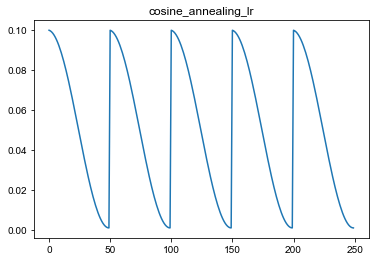

In [48]:
scheduler = CosineAnnealingLR_with_Restart(optimizer, model, '',
                T_max=50, cycle_num=5, take_snapshot=False)
plot_lr(scheduler, 'cosine_annealing_lr', epochs=250)

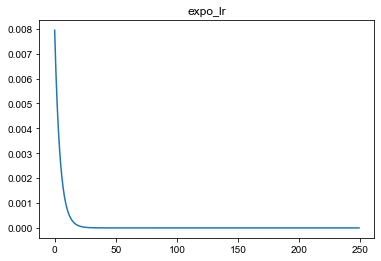

In [151]:
scheduler = optim.lr_scheduler.LambdaLR(optimizer, 
                lr_lambda=lambda epoch:10**(-epoch/10))
plot_lr(scheduler, 'expo_lr', epochs=250)

In [ ]:
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9) #lr = gamma**epoch *lr
plot_lr(scheduler, 'expo_lr', epochs=250)

In [152]:
def load_optimizer_checkpoint(optimizer, pretrained_path, device):
    # 继续训练会要记录上次optimizer的状况
    checkpoint = torch.load(pretrained_path, map_location=device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict']) #参数在cpu
    #param_groups会跟随model.to(device)而转换到gpu，但是state仍然在cpu
    for state in optimizer.state.values(): #取出里面的mementum_buffer
        for k, v in state.items():
            state[k] = v.to(device) #再次分配到gpu
    return optimizer

def load_scheduler_checkpoint(lr_scheduler, pretrained_path, device):
    # 继续训练会要记录上次lr_scheduler的状况
    checkpoint = torch.load(pretrained_path, map_location=device)
    lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    return lr_scheduler

#### Metrics
`train/metrics.py`

In [ ]:
from scipy import interpolate
from sklearn.metris import auc

In [49]:
def accuracy(y_pred, y_true): #用概率更高值来决定类别
    y_pred = torch.argmax(y_pred, axis=1)
    acc = y_pred.eq(y_true) 
    acc = acc.detach().cpu().numpy() 
    acc = np.mean(acc)
    return acc

In [154]:
def confusion_matrix(y_pred, y_true, threshold=0.5, beta=1):
    '''
    Parameters
    ----------
    beta (int): when beta>1, recall-oriented; 
                when beta<1, precision-oriented
    '''
    y_pred = y_pred[:,1]>threshold #用阈值来决定类别
    tp = np.logical_and(y_true==1, y_pred==1).sum()
    fp = np.logical_and(y_true==0, y_pred==1).sum()
    tn = np.logical_and(y_true==0, y_pred==0).sum()
    fn = np.logical_and(y_true==1, y_pred==0).sum()
    
    tpr = 0 if (tp+fn)==0 else tp/(tp+fn)
    fpr = 0 if (tn+fp)==0 else fp/(tn+fp)
    precision = 0 if (tp+fp)==0 else tp/(tp+fp)
    recall = 0 if (tp+fn)==0 else tp/(tp+fn)
    f1 = (1+beta**2)*tp/((1+beta**2)*tp+fn+fp)
    acc = (tp+tn)/(tp+fp+tn+fn)
    metrics = {'tp':tp, 'fp':fp, 'tn':tn, 'fn':fn, 'tpr':tpr, 'fpr':fpr, 
               'precision':precision, 'recall':recall, 'f1':f1, 'acc':acc}
    return metrics

In [51]:
def ACER(y_pred, y_true):
    cm = confusion_matrix(y_pred, y_true)
    apcer = cm['fpr'] #把假人预测为真人的概率
    npcer = 1-cm['tpr'] #把真人预测为假人的概率
    acer = (apcer + npcer) / 2.0 #平均错误概率
    acc = cm['acc'] #一般准确率
    return acer, acc

In [52]:
# 求得当FPR=target时，对应的TPR@FPR=1e-3
def TPR_FPR(y_pred, y_true, fpr_target = 1e-3): #活体检测侧重于最小化fpr，即把假人预测为真人的概率，验证更严格
    threshold = np.arange(0.0, 1.0, 0.001) #在[0,1]之间有多个阈值，根据阈值不同，metrics结果也不一样
    fpr = np.zeros(len(threshold))
    tpr = np.zeros(len(threshold))
    for i, thres in enumerate(threshold):
        metrics = confusion_matrix(y_pred, y_true, thres)
        fpr[i] = metrics['fpr']
        tpr[i] = metrics['recall']
    roc_auc_score = auc(fpr, tpr)
    
    f = interpolate.interp1d(fpr, threshold, kind= 'slinear') #得到threshold=f(fpr)的函数关系
    # 阈值越大越严格，FPR随着阈值减小而变大，当遍历到最小阈值时，代表所有样本都预测为P，除非真实样本确实都为P，否则np.max(fpr)=1
    fpr_target = np.clip(fpr_target, None, np.max(fpr)) #如果target>np.max(fpr)，代表只需要满足最宽松的条件，即最小阈值
    if fpr_target <= np.min(fpr): #但是如果target比可能实现的最小值都小，就只能提高target，同时打印出来告知
        fpr_target = np.min(fpr)
        print(f'FPR target -> {fpr_target}')
    thres = f(fpr_target) #求得在目标fpr下的对应阈值

    metrics = confusion_matrix(y_pred, y_true, thres)
    FPR = metrics['fpr']
    TPR = metrics['recall']
    
    return FPR, TPR, roc_auc_score


#### Train
`train/train_infer.py`

In [53]:
from collections import defaultdict

**<问题>** 训练过程中，Forprop和Backprop大概用时0.9s和2s左右
**<研究方案>** 可以进一步提升训练速度的方案
1. zero_grad  

```python
optimizer.zero_grad() #遍历所有参数执行memset把grad归零  
loss.backward() #计算当前batch的grad同时，读取前一个batch累加的grad并用+=进行相加

# 可以用以下方法代替：  
for param in model.parameters():  
    param.grad = None #不会对参数执行memset，但是用更有效率的方式把grad归零 
loss.backward() #只需要执行=，而不需要花额外时间读取和相加
```

2. cuDNN Autotuner  
设置torch.backends.cudnn.benchmark=True，可以根据当前的设置来选择最优算法来加快训练速度。但是如果input size变化，则会重新选择最优算法，反而使速度会变慢

**<改进和结果>**    
尝试了上述两种方法，速度和原来差别不大，可选。

In [56]:
def train_on_epoch(model, train_loader, criterion, optimizer, 
                   device, iter_smooth = 20):
    n_batches = len(train_loader)
    epoch_loss = 0
    epoch_acc = 0
    for i, (image, label) in enumerate(train_loader):
        model.train() #训练模式
        image = image.to(device) #(b,h,w,c)
        label = label.to(device) #(b,1)
        y_pred = model(image) #(b,2)
        label = label.view(-1) #(b,)
        loss  = criterion(y_pred, label)
        acc = accuracy(y_pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 输出内容
        epoch_loss += loss.item() #累计epoch内batch loss
        epoch_acc += acc.item()
        if i%iter_smooth==0:
            print(f'Batch {i+1}/{n_batches} - loss: {epoch_loss/(i+1):.4f} - acc: {epoch_acc/(i+1):.4f}')         

    epoch_loss /= n_batches #平均epoch loss
    epoch_acc /= n_batches #仅在drop last的时候有效，否则求loss时reduction=‘none'，再除以样本总数
    return epoch_loss, epoch_acc

In [57]:
def val_on_epoch(model, val_loader, criterion, device):
    y_pred_all, y_true_all = [], []
    val_loss = 0
    n_samples = 0
    for i, (image, label) in enumerate(val_loader):
        model.eval() #预测模式，关闭dropout和bn
        b, n, c, h, w = image.shape #多个patches
        n_samples += b 
        image = image.view(b*n, c, h, w).to(device) #把n个patches分开，输入模型
        label = label.to(device)
        with torch.no_grad():
            y_pred = model(image)
            y_pred = y_pred.view(b,n,2) #对每个样本衍生的n个patches求样本类别概率均值 
            y_pred = torch.mean(y_pred, dim=1, keepdim=False) #(b,2)
            label = label.view(-1) #(b,)
            #由于val batch没有drop last，先求样本loss总和，再求样本loss均值
            loss  = criterion(y_pred, label, reduction='sum') 
            val_loss += loss.item() #样本loss总和
            #记录下来一次性计算acc
            y_pred = F.softmax(y_pred, dim=1)
            y_pred_all.append(y_pred.detach().cpu().numpy()) 
            y_true_all.append(label.detach().cpu().numpy())
    
    val_loss /= n_samples #样本loss均值
    y_pred_all = np.concatenate(y_pred_all) #(m,2)
    y_true_all = np.concatenate(y_true_all) #(m,)
    acer, acc = ACER(y_pred_all, y_true_all) 
    fpr, tpr, auc = TPR_FPR(y_pred_all, y_true_all) #得到TPR@FPR=1e-3
    print(f'Validation - loss: {val_loss:.4f} - acer - {acer:.4f} - acc: {acc:.4f} - auc: {auc:.4f}')   
    return val_loss, acer, acc, auc

In [54]:
# 用scheduler训练，且可以validate
def train_with_cosine_lr(model, train_loader, val_loader=None, scheduler=None, 
                         epochs=10, cycle_num=2):
    history = {}
    for i in range(cycle_num):
        print(f'\n*** Cycle {i+1} ***')
        metrics = defaultdict(list)
        for e in range(epochs):        
            print(f'Epoch {e+1}/{epochs} ', end='') #连着输出lr
            if scheduler:
                scheduler.step()
                lr = scheduler.get_last_lr()
                print(f'(lr = {lr:.4f})')
            else:
                print('') #转行
            
            # 训练
            train_loss, train_acc = train_on_epoch(model, train_loader, criterion, optimizer, device)
            metrics['train_loss'].append(train_loss)
            metrics['train_acc'].append(train_acc)
            
            # 验证
            if val_loader:
                val_loss, val_acer, val_acc, val_auc = val_on_epoch(model, val_loader, criterion, device)
                metrics['val_loss'].append(val_loss)
                metrics['val_acer'].append(val_acer)
                metrics['val_acc'].append(val_acc)
                metrics['val_auc'].append(val_auc)
        
        #把每个周期，每个epoch的metrics都保存下来    
        history[i]=metrics 
    return history

In [73]:
#纯训练，用tqdm进度条 
def train(model, train_loader, epochs=1):
    train_loss = []
    train_acc = []
    for e in range(epochs):           
        n_batches = len(train_loader)
        pbar = tqdm(total=n_batches, position=0, leave=True, bar_format='{l_bar}{bar}|') #轮数和进度条
        epoch_loss = 0
        epoch_acc = 0
        for i, (image, label) in enumerate(train_loader):
            model.train() #训练模式
            image = image.to(device) #(b,h,w,c)
            label = label.to(device) #(b,1)
            y_pred = model(image)
            label = label.view(-1)
            loss  = criterion(y_pred, label)
            acc = accuracy(y_pred, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # 输出内容
            epoch_loss += loss.item() #累计epoch内loss
            epoch_acc += acc.item()
            pbar.set_description(f'Epoch {e+1}/{epochs} - Batch {i+1}/{n_batches} - loss: {loss.item():.4f} - acc: {acc:.4f}')  #在进度条前的输出当下batch loss和acc         
            pbar.update() #更新
        pbar.close() #一定要关闭
        epoch_loss /= n_batches #平均epoch loss
        epoch_acc /= n_batches #仅在drop last的时候有效，否则求loss时reduction=‘none'，再除以样本总数
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        print(f'End of Epoch - loss: {epoch_loss:.4f} - acc: {epoch_acc:.4f}')  #在进度条前的输出当下batch loss和acc         
              
    history = {'loss':train_loss, 'accuracy':train_acc}
    return history

In [75]:
def preprocess_for_prediction(path):
    image = cv2.imread(path) 
    image = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE))
    image = augumentor(image, target_shape=(PATCH_SIZE,PATCH_SIZE,3), 
                       is_infer=True, n_patches=36) #(n,h,w,3)
    image = np.transpose(image, (0, 3, 1, 2)) #(n,3,h,w)
    image = image.astype(np.float32)
    image = image / 255.0
    image = torch.FloatTensor(image)
    image = image.unsqueeze(0) #(1,n,3,h,w)
    fake_label = None
    return image, fake_label


def predict(model, test_loader, device): 
    y_pred_all = [] 
    for i, (image, label) in enumerate(test_loader):
        model.eval() #预测模式，关闭dropout和bn
        b, n, c, h, w = image.shape #多个patches
        image = image.view(b*n, c, h, w).to(device) #把n个patches分开，输入模型
        with torch.no_grad():
            y_pred = model(image)
            y_pred = y_pred.view(b,n,2) #对每个样本衍生的n个patches求样本类别概率均值 
            y_pred = torch.mean(y_pred, dim=1, keepdim=False) #(b,2)
            y_pred = F.softmax(y_pred, dim=1) #(b,2) 概率
            y_pred_all.append(y_pred.detach().cpu().numpy())
        
    y_pred_all = np.concatenate(y_pred_all) #(m,2)
    return y_pred_all[:,1] #只返回概率 (m,)

Propability: 0.9618493914604187
Alive: True


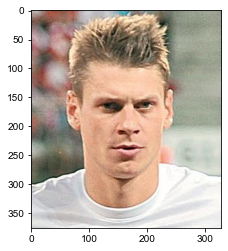

In [213]:
# 预测
path = os.path.join('casia_surf_dataset','real.jpg') #fake.jpg
image, fake_label = preprocess_for_prediction(path) 
y_pred = predict(model, [(image,fake_label)], device) #返回1个概率
y_pred_label = y_pred[0]>0.5 #True/False
print(f'Propability: {y_pred[0]}')
print(f'Alive: {y_pred_label}')
plt.imshow(plt.imread(path));

In [160]:
def submission(filepath, save_path, prob):
    data = pd.read_csv(filepath, sep=' ', names=['color','depth','ir','prob'])
    data['prob'] = prob
    data.to_csv(save_path, header=None, index=None, sep=' ')
    print('Probability has been updated')
    return data

In [161]:
def ensemble(models, test_loader):
    tmp_pred  = 0
    for model in models:
        y_pred = predict(model, test_loader)
        tmp_pred += y_pred #累加
        filename = os.path.join('prediction', f'{type(model).__name__}.txt')
        submission(os.path.join(DATA_ROOT, TEST_PATH_LIST), filename , y_pred) #保存每个模型结果

    tmp_pred /= len(predictions)
    filename = os.path.join('prediction', 'ensemble.txt')   
    data = submission(os.path.join(DATA_ROOT, TEST_PATH_LIST), filename, tmp_pred) #保存ensemble结果
    return data

> ### Demo

#### Utils
`utils.py`

In [ ]:
def time_to_str(t):
    hr = int(t/60)//60
    minute = int(t/60)%60
    sec = int(t)%60   
    return f'{hr:02}h {minute:02}m {sec:02}s'

In [ ]:
class Logger(object):
    def __init__(self):
        self.terminal = sys.stdout  #在终端的输出
        self.file = None

    def open(self, file, mode='w'): #默认新建日志
        self.file = open(file, mode)

    def write(self, message, is_terminal=0, is_file=1):
        if is_terminal == 1:
            self.terminal.write(message) #在终端输出日志
            self.terminal.flush()
            #time.sleep(1)

        if is_file == 1:
            self.file.write(message) #在文件输出日志
            self.file.flush()

#### Main
`main.py`

In [ ]:
import sys
import argparse
import pickle
import time

In [ ]:
def run_train(config):
    out_dir = 'running_log' #保存训练日志和模型的路径
    if config.modality=='fusion':
        config.model_name = f"FaceBagNet_{config.model}_{'att_' if config.attention else ''}{'neck_' if config.bottleneck else ''}{str(config.patch_size)}"
    else:
        config.model_name = f"FaceBagNet_{config.model}_{config.modality}_{str(config.patch_size)}"
    out_dir = os.path.join(out_dir,config.model_name)
    checkpoint_dir = os.path.join(out_dir, 'checkpoint')
    if not os.path.exists(checkpoint_dir): 
        os.makedirs(checkpoint_dir)
    
    # ------setup------
    log = Logger()
    log.open(os.path.join(out_dir, f'{config.model_name}_training.txt'), mode='a') #增加内容
    log.write(f'Training log @ {out_dir}\n')
    
    # ------device------
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    gpu_num = torch.cuda.device_count()
    log.write(f'Device: {device}\n')
    log.write('\n')
    
    #------dataset------
    log.write('** Dataset setting **\n')
    if device.__str__() == 'cuda':
        num_workers = 16
        pin_memory = True #使用锁页内存加速复制数据到gpu
    else:
        num_workers = cpu_cores
        pin_memory = False

    train_dataset = FDDataset(mode = 'train', modality=config.modality, patch_size=config.patch_size)
    train_loader  = DataLoader(train_dataset, shuffle=True, batch_size = config.batch_size,
                                drop_last = True, num_workers = num_workers, pin_memory=pin_memory)

    valid_dataset = FDDataset(mode = 'val', modality=config.modality, patch_size=config.patch_size)
    valid_loader  = DataLoader(valid_dataset, shuffle=False, batch_size  = config.batch_size,
                               drop_last = False, num_workers = num_workers, pin_memory=pin_memory)
    assert(len(train_dataset)>=config.batch_size)
    log.write(f'training_samples = {train_dataset.__len__()}\n')
    log.write(f'val_samples = {valid_dataset.__len__()}\n')
    log.write(f'batch_size = {config.batch_size}\n')
    log.write(f'modality = {config.modality}\n')
    log.write(f'patch_size = {config.patch_size}\n') 
    log.write('\n')
    
    #------model------
    log.write('** Model setting **\n')
    model = get_model(name=config.model, modality=config.modality, num_classes=2, 
                      attention=config.attention, bottleneck=config.bottleneck)
    log.write(f'Model: {type(model).__name__}\n')
    model.to(device) #先分配给gpu
    log.write('\n')
    
    #------train------
    log.write('** Training setting **\n')
    criterion = F.cross_entropy
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                      lr=0.01, momentum=0.9, weight_decay=0.005)
    scheduler = CosineAnnealingLR_with_Restart(optimizer, model, checkpoint_dir,
                T_max=config.epoch_inter, cycle_num=config.cycle_num) 
    log.write(f'criterion = {criterion.__name__}\n')
    log.write(f'optimizer = {type(optimizer).__name__}\n')
    log.write(f'scheduler = {type(scheduler).__name__}\n')
    log.write(f'cycle_num = {config.cycle_num}\n')
    log.write(f'epochs_per_cycle = {config.epoch_inter}\n')
    log.write('\n')

    #------pretrained------
    pretrained_path = config.pretrained_model
    if pretrained_path is not None: 
        pretrained_path = os.path.join(checkpoint_dir, pretrained_path)
        log.write(f'Loading initial_checkpoint: {pretrained_path}\n')
        model.load_pretrained(pretrained_path, device) #加载完之后，再用DP
        optimizer, scheduler = load_pretrained(optimizer, scheduler, pretrained_path, device)
        log.write('\n')

    model = nn.DataParallel(model) #包裹在DataParallel module下，所以pretrained模型的参数名最外层是module.
        
    #------log------
    log.write('** Start training here! **\n')
    pattern1="{: ^18}|{:-^16}|{:-^24}|\n" #开头第一行
    pattern2="{: ^6}"*3+"|"+"{: ^8}"*2+"|"+"{: ^8}"*3+"|"+"{: ^12}\n" #标题行
    pattern3="{: ^6}"*2+"{: ^6.4f}"+"|"+"{: ^8.4f}"*2+"|"+"{: ^8.4f}"*3+"|"+"{: ^12}\n" #内容行
    log.write(pattern1.format('',' TRAIN ',' VALID '))
    log.write(pattern2.format('cycle','epoch','lr','loss','acc','loss','acer','acc','time'))
    log.write("-"*73+'\n')
    result = pd.DataFrame(columns=['model','cycle','epoch','lr','train_loss','train_acc','val_loss','val_acer','val_acc']) #记录最优轮数的metrics
    
    history = {}
    start = time.time() #计时
    global_min_acer = 1.0 #所有周期内的最小acer
    for i in range(config.cycle_num):
        print(f'*** Cycle {i+1} ***')
        min_acer = 1.0 #本周期内的最小acer
        val_loss, val_acer, val_acc = 0,0,0 #前半周期不做validation
        metrics = defaultdict(list)
        for e in range(config.epoch_inter):        
            print(f'Epoch {e+1}/{config.epoch_inter} ', end='')
            if scheduler:
                scheduler.step()
                lr = scheduler.get_last_lr()
                print(f'(lr = {lr:.4f})')
            
            # 训练
            train_loss, train_acc = train_on_epoch(model, train_loader, criterion, optimizer, device)
            metrics['train_loss'].append(train_loss)
            metrics['train_acc'].append(train_acc)
            
            # 验证
            if e >= config.epoch_inter // 2: #由于前半周期肯定不断进步，只在下半周期做validation
                val_loss, val_acer, val_acc = val_on_epoch(model, valid_loader, device)
                metrics['val_loss'].append(val_loss)
                metrics['val_acer'].append(val_acer)
                metrics['val_acc'].append(val_acc)
                end = time.time() #每个epoch结束后计算一次累计时间
                log.write(pattern3.format(i+1, e+1, lr, train_loss, train_acc, 
                          val_loss, val_acer, val_acc, time_to_str(end - start)))
            
                # 保存周期内、全局最优模型，和周期末模型
                if val_acer < min_acer:
                    min_acer = val_acer #更新最小acer值
                    ckpt_path = os.path.join(checkpoint_dir, f'cycle{i+1:02}_min_acer_model.pth') #每个周期仅保存一个最优模型
                    torch.save({
                        'state_dict': model.state_dict(), #模型参数w/b信息
                        'optimizer_state_dict': optimizer.state_dict(), #包括bn的running mean和std等信息
                    }, ckpt_path)
                    log.write(f'Saving cycle {i+1} min acer model: {min_acer}\n')
                    result.loc[i] = [config.model_name, i+1, e+1, lr, train_loss, train_acc, val_loss, val_acer, val_acc]

                if val_acer < global_min_acer:
                    global_min_acer = val_acer #更新最小acer值
                    ckpt_path = os.path.join(checkpoint_dir, f'global_min_acer_model.pth') #仅保存一个全局最优模型
                    torch.save({
                        'state_dict': model.state_dict(), #模型参数w/b信息
                        'optimizer_state_dict': optimizer.state_dict(), #包括bn的running mean和std等信息
                    }, ckpt_path)
                    log.write(f'Saving global min acer model: {global_min_acer}\n')
                    result.loc[config.cycle_num] = [config.model_name, f'Global - {i+1}', e+1, lr, train_loss, train_acc, val_loss, val_acer, val_acc]
            else:
                end = time.time() #每个epoch结束后计算一次累计时间
                log.write(pattern3.format(i+1, e+1, lr, train_loss, train_acc, 
                          val_loss, val_acer, val_acc, time_to_str(end - start)))
        
        ckpt_path = os.path.join(checkpoint_dir, f'cycle{i+1:02}_final_model.pth') #每个周期仅保存一个最优模型
        torch.save({'state_dict': model.state_dict(), #模型参数w/b信息
                    'optimizer_state_dict': optimizer.state_dict(), #包括bn的running mean和std等信息
                    }, ckpt_path)
        log.write(f'Saving cycle {i+1} final model: {val_acer}\n')   
        history[i+1]=metrics 
    
    #保存每个周期，每个epoch的结果，方便后续可视化查看训练情况
    pickle.dump(history, open(os.path.join(out_dir, f'{config.model_name}_history.pkl'),'wb'))
    # 保存每个周期和全局最优结果，方便后续多个模型间进行比较
    result.to_csv(os.path.join(out_dir, f'{config.model_name}_result.txt'), index=False)
    return history, result
    

In [ ]:
def run_test(config):
    out_dir = 'running_log' #保存训练日志和模型的路径
    if config.modality=='fusion':
        config.model_name = f"FaceBagNet_{config.model}_{'att_' if config.attention else ''}{'neck_' if config.bottleneck else ''}{str(config.patch_size)}"
    else:
        config.model_name = f"FaceBagNet_{config.model}_{config.modality}_{str(config.patch_size)}"
    out_dir = os.path.join(out_dir,config.model_name)
    checkpoint_dir = os.path.join(out_dir, 'checkpoint')
    
    # ------device------
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    gpu_num = torch.cuda.device_count()
    
    #------dataset------
    test_dataset = FDDataset(mode = 'test', modality=config.modality, patch_size=config.patch_size)
    test_loader  = DataLoader(test_dataset, shuffle=False, 
                              batch_size = config.batch_size,
                              drop_last = True, num_workers = gpu_num)
    print(f'Loading {test_dataset.__len__()} test samples...')
    
    #------model------
    model = get_model(name=config.model, modality=config.modality, num_classes=2, 
                      attention=config.attention, bottleneck=config.bottleneck)
    model.to(device)

    pretrained_path = config.pretrained_model
    if pretrained_path is not None: 
        pretrained_path = os.path.join(checkpoint_dir, pretrained_path)
        print(f'Loading initial_checkpoint: {pretrained_path}\n')
        model.load_pretrained(pretrained_path, device)
    model = nn.DataParallel(model)
    
    #------log------
    print('** Start predicting here! **\n')
    model.eval()
    prob = predict(model, test_loader, device) #得到真人的概率
    save_path = os.path.join(out_dir, f'{config.model_name}_prediction.txt')
    submission(TEST_PATH_LIST, save_path, prob)

In [ ]:
def main(config):
    if config.mode == 'train':
        run_train(config)

    if config.mode == 'infer_test':
        config.pretrained_model = 'global_min_acer_model.pth'
        run_test(config)

In [ ]:
class Config():
    modality='fusion'
    patch_size=48
    model='ResNet18'
    attention=True
    bottleneck=False
    batch_size=2
    cycle_num=2
    epoch_inter=10
    mode='train'
    pretrained_model=None
    
config = Config()

In [ ]:
main(config)

把config用以下Command arg方式定义，运行脚本`CUDA_VISIBLE_DEVICES=0 python main.py --model=SE-ResNeXt18 --bottleneck=True --modality=fusion --patch_size=48`

In [ ]:
# 在终端运行模型时，用命令行参数解析设置config
parser = argparse.ArgumentParser()
# dataset
parser.add_argument('--modality', type=str, default='fusion', choices=['fusion','color','depth','ir'])
parser.add_argument('--patch_size', type=int, default=48)

# model
parser.add_argument('--model', type=str, default='ResNet18', 
                    choices=['ResNet18', 'SENet154', 'SE-ResNet', 'SE-ResNeXt18', 'SE-ResNeXt34', 'SE-ResNeXt50'])
parser.add_argument('--attention', type=bool, default=False, help='with SE Module to screen out multi-modal features')
parser.add_argument('--bottleneck', type=bool, default=False, help='with SE-ResNeXt Bottleneck instead of ResNet Basic Block')

# train
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--cycle_num', type=int, default=1)
parser.add_argument('--epoch_inter', type=int, default=20, help='epochs per lr schedule cycle')
parser.add_argument('--mode', type=str, default='train', choices=['train','infer_test'])
parser.add_argument('--pretrained_model', type=str, default=None) #预训练模型路径

config = parser.parse_args()
print(config)

>### Evaluation

单模态模型：用Cosine退火从lr=0.1-0.001训练20个epochs，再用Expo lr从lr=0.001开始训练10个epochs：

| Single-modal Model    |  ACER  |   ACC  |  Loss  | AUC   |
| --------------------- | ------ | ------ | ------ | ----  |
| ResNet18              | 0.0448 | 0.9552 | 0.1359 | 0.9805|
| SE-ResNet             | 0.0837 | 0.9163 | 0.1962 | 0.9802| 
| SE-ResNeXt18          | 0.0521 | 0.9480 | 0.1636 |
| SE-ResNeXt50          | 0.0599 | 0.9405 | 0.1540 |


In [ ]:
def plot_graphs(history, string):
    plt.plot(history[string])
    plt.xlabel("Epochs")
    plt.title(string.capitalize())
    plt.show()

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

>### Deployment  

#### Pruning
`model/pruning.py`
待进一步研究：
- 按filter剪枝的时候，更好处理并行结构的情况，保证前后层匹配
- 部分参数归零之后，进一步使模型尺寸变小

In [17]:
from torch.nn.utils import prune
import copy
import gc 

In [18]:
def sparsity(model): #模型参数稀疏程度%
    num, zero_num = 0., 0.
    for p in model.parameters(): #遍历参数
        num += p.numel() #参数值个数
        zero_num += (p == 0).sum() #参数值为0的个数
    return zero_num / num

In [19]:
def prune_value(model, amount=0.3): #以参数值为单位进行归零
    print(f'Before pruning: {sparsity(model):.2%} global sparsity')
    for m in model.modules(): #从外层到内层逐步遍历
        if isinstance(m, nn.Conv2d):
            #从L1 norm最小的参数开始归零，返回weight_orig和对应的weight_mask
            prune.l1_unstructured(m, name='weight', amount=amount)  
            prune.remove(m, 'weight')  #把mask和原参数值相乘
    print(f'After pruning: {sparsity(model):.2%} global sparsity')
    model = reduce_mem(model)
    print(f'After pruning: {sparsity(model):.2%} global sparsity')
    return model

# def reduce_mem(model):
#     for m in model.modules(): #从外层到内层逐步遍历
#         if isinstance(m, nn.Conv2d):
#             dtype = m.weight.data.dtype
#             # 获得数值范围
#             m_min = m.weight.data.min() 
#             m_max = m.weight.data.max()
            
#             # 整数
#             if dtype == torch.int:
#                 if m_min > np.iinfo(np.int8).min and m_max < np.iinfo(np.int8).max:
#                     m.weight.data = m.weight.data.to(torch.int8)
#                 elif m_min > np.iinfo(np.int16).min and m_max < np.iinfo(np.int16).max:
#                     m.weight.data = m.weight.data.to(torch.int16)
#                 elif m_min > np.iinfo(np.int32).min and m_max < np.iinfo(np.int32).max:
#                     m.weight.data = m.weight.data.to(torch.int32)
#                 elif m_min > np.iinfo(np.int64).min and m_max < np.iinfo(np.int64).max:
#                     m.weight.data = m.weight.data.to(torch.int64)
            
#             # 浮点数
#             elif dtype == torch.float:
#                 if m_min > np.finfo(np.float16).min and m_max < np.finfo(np.float16).max:
#                     m.weight.data = m.weight.data.to(torch.float16)
#                 elif m_min > np.finfo(np.float32).min and m_max < np.finfo(np.float32).max:
#                     m.weight.data = m.weight.data.to(torch.float32)
#                 else:
#                     m.weight.data = m.weight.data.to(torch.float64)
#     gc.collect() #对已经销毁或del的对象，Python不会自动释放内存，需要使用gc回收内存
#     return model

In [20]:
def prune_filter(model, amount=0.1): #以filter为单位进行裁剪
    print(f'Before pruning: {sparsity(model):.2%} global sparsity')
    pre_layer = None #前层Conv
    pre_layer_bn = None #前层Bn
    pre_pruned_idx = None #前层被裁掉的filter dix
    
    for m in model.modules(): #只适用于串联结构模型
        # 主要目的是prune Conv2d的filter
        if isinstance(m, nn.Conv2d):
            out_chans, in_chans, f, _ = m.weight.shape 
            print(m)
            print(f'Weight: {m.weight.shape} -> ', end='')
            
            # 如果由于前层Conv/Bn去掉filters，导致input feature map缺失，需要先把受前层影响的卷积核去掉
            if pre_layer is not None and pre_pruned_idx is not None:
                if m.groups == 1: #当前层准备做正常卷积
                    m.weight.data = np.delete(m.weight.data, pre_pruned_idx, axis=1) #裁掉
                    m.in_channels = m.weight.shape[1] #需要手动更改in_chans
                    print(f'{m.weight.shape} -> ', end='')
                else: #但是如果当前层准备做group卷积，前层缺少的feature map会影响某些分组，导致运算无法正常进行
                    pre_layer.weight.data = backup_conv_w #恢复前层Conv原参数，不做裁剪
                    if pre_layer.bias is not None: #如果存在bias也复原，虽然BN前的Conv通常没有设置bias，但如果不接BN就很有可能带bias
                        pre_layer.bias.data = backup_conv_b 
                    pre_layer.out_channels = backup_conv_w.shape[0] 
                    
                    if pre_layer_bn is not None: #如果Conv后还跟了BN，一起恢复
                        pre_layer_bn.weight.data = backup_bn
                        pre_layer_bn.num_features = backup_bn.shape[0]
                    
            # 再把当前层从L2 norm最小的filter开始去掉
            l2_norm, idx = (m.weight**2).sum(dim=[1,2,3]).sort() #根据filters的L2 norm排序，为简化计算免去np.sqrt
            pruned_num = int(out_chans*amount) #根据每层filters数，裁剪amount%
            pruned_idx = idx[:pruned_num] #需要裁掉的filter idx
            backup_conv_w = m.weight.data.clone() #由于会影响下一层，先为后续运算备份数据
            
            m.weight.data = np.delete(m.weight.data, pruned_idx, axis=0) #裁掉
            m.out_channels = m.weight.shape[0] #需要手动更改out_chans
            print(m.weight.shape)
            
            if m.bias is not None: #如果存在bias，因为BN前的Conv通常没有设置bias
                print(f'Bias: {m.bias.shape} -> ', end='')
                backup_conv_b = m.bias.data
                m.bias.data = np.delete(m.bias.data, pruned_idx, axis=0) #裁掉
                print(f'{m.bias.shape}')
            pre_layer = m #作为下一层的前层
            pre_pruned_idx = pruned_idx 
            
                      
        # 通常跟在pruned Conv后，out_chans会受影响
        if isinstance(m, nn.BatchNorm2d): 
            if pre_layer is not None and pre_pruned_idx is not None: #以防是在模型开头做normalization
                backup_bn = m.weight.data
                m.weight.data = np.delete(m.weight.data, pre_pruned_idx, axis=0) #裁掉, BN只是针对每个(out_chans,)有running mean/std
                m.num_features = m.weight.data.shape[0]
                pre_layer_bn = m #额外保存作为前层bn，因为如果下一层Group Conv需要复原前层，那么需要把Conv和Bn同时恢复，不能只恢复Bn
        
        #由于FC通常在模型最后，前层一般是pruned Conv/bn+GAP，维持裁剪后的out_chans
        #但是如果前面有Flatten重置out_chans就不适用
        if isinstance(m, nn.Linear): 
            if pre_layer is not None and pre_pruned_idx is not None: #以防是在模型开头做normalization
                m.weight.data = np.delete(m.weight.data, pre_pruned_idx, axis=1) #裁掉
                m.in_features = m.weight.data.shape[1]
                pre_layer = None #由于FC不做裁剪，不会影响后续层
                pre_pruned_idx = None
            
    print(f'After pruning: {sparsity(model):.2%} global sparsity')
    return model

In [14]:
# 加载预训练模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_model('ResNet18', modality='color', attention=False, bottleneck=False)
# pretrained_path = os.path.join('running_log', 'SE-ResNeXt18_color_48', 'checkpoint', 'global_min_acer_model2.pth')
pretrained_path = os.path.join('running_log', 'ResNet18_color_48', 'checkpoint', 'global_min_acer_model.pth')
model = load_model_checkpoint(model, pretrained_path, device)    
summary(model, (3, 48, 48))

/opt/anaconda3/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/anaconda3/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torchvision.models.resnet.ResNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/anaconda3/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attr

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 48, 48]               6
            Conv2d-2           [-1, 64, 24, 24]           9,408
            Conv2d-3           [-1, 64, 24, 24]           9,408
       BatchNorm2d-4           [-1, 64, 24, 24]             128
       BatchNorm2d-5           [-1, 64, 24, 24]             128
              ReLU-6           [-1, 64, 24, 24]               0
              ReLU-7           [-1, 64, 24, 24]               0
         MaxPool2d-8           [-1, 64, 12, 12]               0
         MaxPool2d-9           [-1, 64, 12, 12]               0
           Conv2d-10           [-1, 64, 12, 12]          36,864
           Conv2d-11           [-1, 64, 12, 12]          36,864
      BatchNorm2d-12           [-1, 64, 12, 12]             128
      BatchNorm2d-13           [-1, 64, 12, 12]             128
             ReLU-14           [-1, 64,

In [220]:
pruned_model = copy.deepcopy(model)
pruned_model = prune_value(pruned_model, 0.5) #归零不会减小模型

Before pruning: 0.00% global sparsity
After pruning: 47.14% global sparsity


In [224]:
summary(pruned_model,(3,48,48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 48, 48]               6
            Conv2d-2           [-1, 64, 24, 24]           9,408
            Conv2d-3           [-1, 64, 24, 24]           9,408
       BatchNorm2d-4           [-1, 64, 24, 24]             128
       BatchNorm2d-5           [-1, 64, 24, 24]             128
              ReLU-6           [-1, 64, 24, 24]               0
              ReLU-7           [-1, 64, 24, 24]               0
         MaxPool2d-8           [-1, 64, 12, 12]               0
         MaxPool2d-9           [-1, 64, 12, 12]               0
           Conv2d-10           [-1, 64, 12, 12]          36,864
           Conv2d-11           [-1, 64, 12, 12]          36,864
      BatchNorm2d-12           [-1, 64, 12, 12]             128
      BatchNorm2d-13           [-1, 64, 12, 12]             128
             ReLU-14           [-1, 64,

In [230]:
pruned_model = copy.deepcopy(model)
pruned_model = prune_filter(pruned_model, 0.5) #归零不会减小模型

Before pruning: 0.00% global sparsity
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Weight: torch.Size([64, 3, 7, 7]) -> torch.Size([32, 3, 7, 7])
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Weight: torch.Size([64, 64, 3, 3]) -> torch.Size([64, 32, 3, 3]) -> torch.Size([32, 32, 3, 3])
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Weight: torch.Size([64, 64, 3, 3]) -> torch.Size([64, 32, 3, 3]) -> torch.Size([32, 32, 3, 3])
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Weight: torch.Size([64, 64, 3, 3]) -> torch.Size([64, 32, 3, 3]) -> torch.Size([32, 32, 3, 3])
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Weight: torch.Size([64, 64, 3, 3]) -> torch.Size([64, 32, 3, 3]) -> torch.Size([32, 32, 3, 3])
Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Weight: torch.Size([128, 64, 3, 3]) -> torch.Size([

IndexError: index 85 is out of bounds for axis 0 with size 64

Propability: 0.9618493914604187
Alive: True


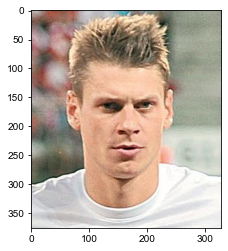

In [213]:
# 裁剪前的模型performance
path = os.path.join(DATA_ROOT, 'real.jpg') #fake.jpg
image, fake_label = preprocess_for_prediction(path) 
y_pred = predict(model, [(image,fake_label)], device) #返回1个概率
label = y_pred[0]>0.5 #True/False
print(f'Propability: {y_pred[0]}')
print(f'Alive: {y_pred_label}')
plt.imshow(plt.imread(path));

Propability: 0.9416361451148987
Alive: True


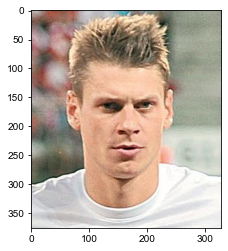

In [222]:
# 验证裁剪后的模型performance
y_pred = predict(pruned_model, [(image,fake_label)], device) #返回1个概率
y_pred_label = y_pred[0]>0.5 #True/False
print(f'Propability: {y_pred[0]}')
print(f'Alive: {y_pred_label}')
plt.imshow(plt.imread(path));

#### Pretrained

`face_anti_spoofing.py`：训练完成后，把效果最好的单模态RGB模型整理入文档，方便后续活体检测调用。

In [1]:
import os
import torch
import sys
current_dir = os.path.abspath('./face_anti_spoofing') #从上一级路径的总项目调用时
# current_dir = os.path.abspath('./') #从当前路径调用时
sys.path.append(os.path.join(current_dir,'model')) #增加绝对路径
sys.path.append(os.path.join(current_dir, 'preprocess'))
sys.path.append(os.path.join(current_dir, 'train'))
from model.facebagnet import *
from preprocess.augmentation import *
from train.train_infer import *
from casia_surf_dataset.load_data import *

In [13]:
class FaceAntiSpoofing():
    def __init__(self, modality='color', patch_size=48):
        self.modality = modality
        self.patch_size = patch_size
        
        # 加载预训练模型
        pretrained_models = {'color':  {'name': 'SE-ResNeXt18', 'attention':False, 'checkpoint': os.path.join('running_log','SE-ResNeXt18_color_48', 'checkpoint', 'global_min_acer_model.pth')},
                                       # {'name': 'ResNet18', 'attention':False, 'checkpoint': os.path.join('running_log','ResNet18_color_48', 'checkpoint', 'global_min_acer_model.pth')},
                             'fusion': {'name': 'ResNet18', 'attention': True, 'checkpoint': os.path.join('running_log','FaceBagNet_ResNet18_att_48', 'checkpoint', 'global_min_acer_model.pth')}}
        model_name = pretrained_models[self.modality]['name']
        attention = pretrained_models[self.modality]['attention']
        pretrained_path = pretrained_models[self.modality]['checkpoint']
        self.model = get_model(name=model_name, modality=self.modality, num_classes=2, attention=attention)
        self.model = load_model_checkpoint(self.model, pretrained_path, device)
        self.model.to(device)
        
    def classify(self, image): 
        # 预处理图片，得到多个patches
        image = cv2.resize(image, (IMAGE_SIZE,IMAGE_SIZE))
        image = augumentor(image, target_shape=(self.patch_size, self.patch_size, 3), 
                           is_infer=True, n_patches=36) #(n,h,w,3)
        image = np.transpose(image, (0, 3, 1, 2)) #(n,3,h,w)
        image = image.astype(np.float32)
        image = image / 255.0
        image = torch.FloatTensor(image)
        image = image.unsqueeze(0) #(1,n,3,h,w)
        fake_label = None

        # 预测
        y_pred = predict(self.model, [(image,fake_label)], device) #返回1个概率
        y_pred_label = y_pred[0]>0.5 #True/False
        return y_pred_label, y_pred[0]

In [14]:
# 调用活体检测模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
anti_spoofing = FaceAntiSpoofing()

In [8]:
# 随机抽取图片
data = load_data_list(os.path.join(DATA_ROOT,VAL_LIST)) 
n_samples = data.shape[0]

We have loaded 9608 samples: 2994 real faces, and 6614 fake faces.


In [9]:
# 随机抽取图片
data = load_data_list(os.path.join(DATA_ROOT,VAL_LIST)) 
n_samples = data.shape[0]

We have loaded 9608 samples: 2994 real faces, and 6614 fake faces.


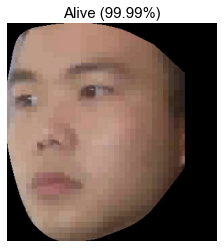

In [118]:
idx = np.random.choice(n_samples)
path = os.path.join(DATA_ROOT, data['color'][idx])
image = cv2.imread(path)
label, prob = anti_spoofing.classify(image)
plt.imshow(image[...,::-1])
plt.title(f'Alive ({prob:.2%})' if label else f'Attack ({1-prob:.2%})',fontsize=15)
plt.axis('off');

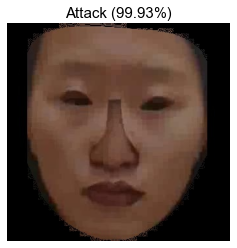

In [119]:
path = os.path.join(DATA_ROOT, 'fake.jpg')
image = cv2.imread(path)
label, prob = anti_spoofing.classify(image)
plt.imshow(image[...,::-1])
plt.title(f'Alive ({prob:.2%})' if label else f'Attack ({1-prob:.2%})',fontsize=15)
plt.axis('off');